In [1]:
import os
import matplotlib.pyplot as plt
import IPython.display as ipd
import math
import scipy
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import models, layers

#### File loading

In [2]:
artifact_files = os.listdir('data/Atraining_artifact')
extrahs_files = os.listdir('data/Atraining_extrahs')
murmur_files = os.listdir('data/Atraining_murmur')
normal_files = os.listdir('data/Atraining_normal')
unlabelledtest_files = os.listdir('data/Aunlabelledtest')

print('Length of artifact_files:', len(artifact_files))
print('Length of extrahs_files:', len(extrahs_files))
print('Length of murmur_files:', len(murmur_files))
print('Length of normal_files:', len(normal_files))
print('Length of unlabelledtest_files:', len(unlabelledtest_files))

Length of artifact_files: 40
Length of extrahs_files: 19
Length of murmur_files: 34
Length of normal_files: 31
Length of unlabelledtest_files: 52


#### Pre-process data

In [4]:
# The function does the following things:
# 1. Load a file folder directory
# 2. Read in one single file_data
# 3. Regulate the data magnitude
# 4. Create small samples: Sample frame = 3 seconds, then hop = 1 second/sample
# 5. Repeat for all samples, and put into the same numpy array
# Output is a numpy array of (#samples * #data_in_3_seconds)

def process_data(files, directory, sr=22050, frame_time=3, hop_time=1):
    frame_len = sr * frame_time
    hop_len = sr * hop_time
    data_output = np.zeros((1,frame_len))
    for file in files:
        # Load a file data from folder directory
        data, _ = librosa.load(directory + '/' + file)
        # Regulate magnitude
        data = data / np.amax(abs(data))
        # Pad the data if total_length < frame_time
        if len(data) <= frame_len:
            data = librosa.util.fix_length(data, size=frame_len)
            data_output = np.append(data_output, [data], axis=0)
        else:
            num_frame = int((len(data)-frame_len)/hop_len)+1
            for i in range(num_frame):
                data_output = np.append(data_output, [data[hop_len*i:hop_len*i+frame_len]], axis=0)
            if (len(data)-frame_len) // hop_len != 0: 
                data_output = np.append(data_output, [data[-frame_len:]], axis=0)
    data_output = data_output[1:,:]        
    return data_output

In [5]:
# load and pre-process data
data_artifact_0 = process_data(artifact_files, 'data/Atraining_artifact')
print('Finished loading data_artifact:', data_artifact_0.shape)
data_normal_0 = process_data(normal_files, 'data/Atraining_normal')
print('Finished loading data_normal:', data_normal_0.shape)
data_murmur_0 = process_data(murmur_files, 'data/Atraining_murmur')
print('Finished loading data_murmur:', data_murmur_0.shape)
data_extrahs_0 = process_data(extrahs_files, 'data/Atraining_extrahs')
print('Finished loading data_extrahs:', data_extrahs_0.shape)

Finished loading data_artifact: (320, 66150)
Finished loading data_normal: (197, 66150)
Finished loading data_murmur: (201, 66150)
Finished loading data_extrahs: (108, 66150)


#### Create labels

In [6]:
label_names = ['artifact', 'normal', 'murmur', 'extrahs']
label_artifact = [0 for item in data_artifact_0]
label_normal = [1 for item in data_normal_0]
label_murmur = [2 for item in data_murmur_0]
label_extrahs = [3 for item in data_extrahs_0]

#### Add a band pass filter to the signal
Some of the raw sound wave signal has high level noise, which may cause unnecessary confusion to the later machine learning process. Since a typical heartbeat sound has frequencies range from 20Hz to 50 Hz, we can use a band pass filter to filter out the unwanted noise out of the interested frequency range. Furthermore, considering we are also categorizing murmur heart beat sounds, in order to include the "murmur" sound, the upper limit for the band pass filter is lifted up to 150Hz.

In [7]:
# define a general band_pass_filter
# input_data can also be a matrix>. In that case, the ourput_data will be a matrix of same dimension.
def band_pass_filter(input_data, lowcut, highcut, fs, order=2, axis=0):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # b and a are coefficients of the order=order bandpass filter
    b, a = scipy.signal.butter(order, [low, high], btype='bandpass', analog=False)
    output_data = scipy.signal.filtfilt(b, a, input_data, axis=axis)    
    return output_data

In [8]:
sr = 22050
# apply band_pass_filter to all the data
data_artifact = band_pass_filter(data_artifact_0, 20, 150, sr/2, axis=1)
print('Finished adding band pass filter to data_artifact:', data_artifact.shape)
data_normal = band_pass_filter(data_normal_0, 20, 150, sr/2, axis=1)
print('Finished adding band pass filter to data_normal:', data_normal.shape)
data_murmur = band_pass_filter(data_murmur_0, 20, 150, sr/2, axis=1)
print('Finished adding band pass filter to data_murmur:', data_murmur.shape)
data_extrahs = band_pass_filter(data_extrahs_0, 20, 150, sr/2, axis=1)
print('Finished adding band pass filter to data_extrahs:', data_extrahs.shape)

Finished adding band pass filter to data_artifact: (320, 66150)
Finished adding band pass filter to data_normal: (197, 66150)
Finished adding band pass filter to data_murmur: (201, 66150)
Finished adding band pass filter to data_extrahs: (108, 66150)


The following audio samples and waveform plots shows the data before and after band pass filtering. Note that,
1. The noise level is significantly reduced.
2. The properties of "murmur" sound is retained.

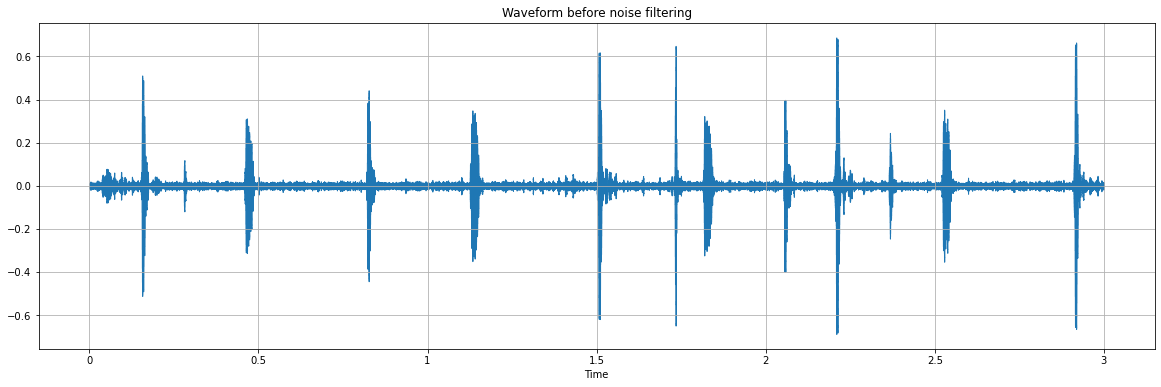

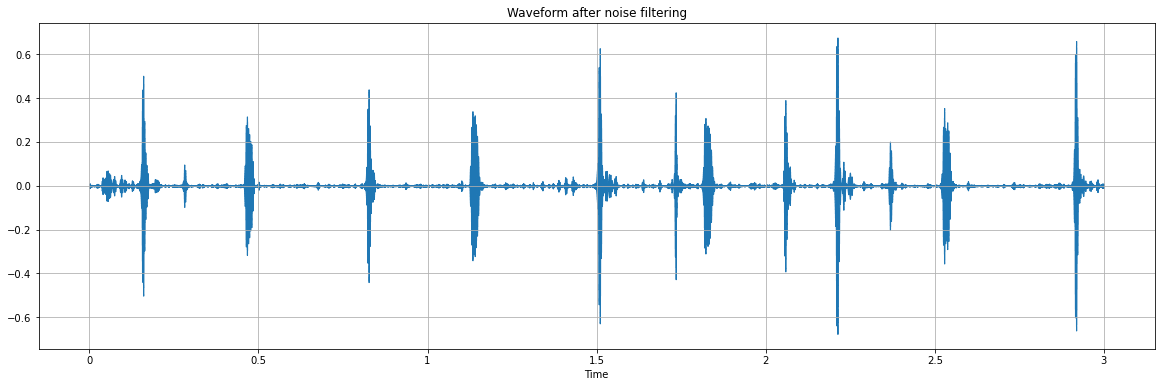

In [9]:
# The following sample shows noise reduction
sr = 22050
num = 0
data_0 = data_normal_0[num]
data = data_normal[num]

# Plot the data before noise filtering
plt.figure(figsize=(20,6))
librosa.display.waveshow(data_0, sr=sr)
plt.title('Waveform before noise filtering')
plt.grid()
plt.show()
ipd.display(ipd.Audio(data=data_0, rate=sr))

# Plot the data after noise filtering
plt.figure(figsize=(20,6))
librosa.display.waveshow(data, sr=sr)
plt.title('Waveform after noise filtering')
plt.grid()
plt.show()
ipd.display(ipd.Audio(data=data, rate=sr))

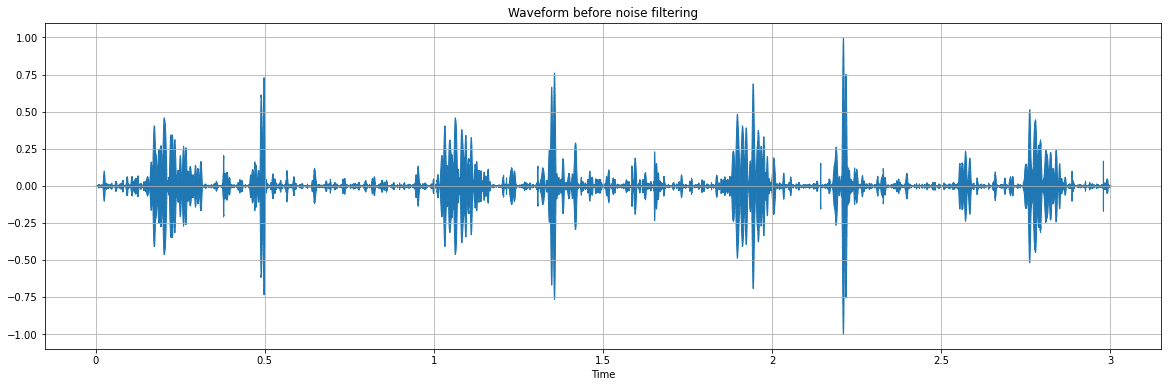

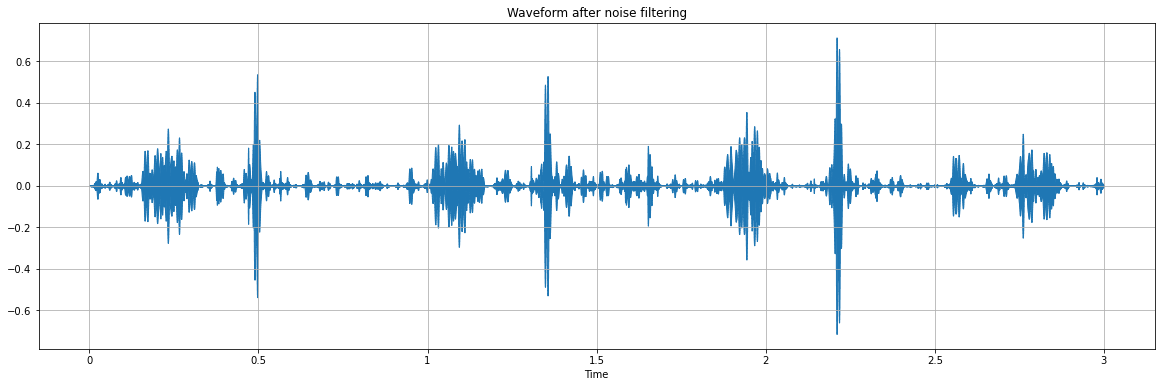

In [10]:
# The following sample shows retain of "murmur" sound
sr = 22050
num = 5
data_0 = data_murmur_0[num]
data = data_murmur[num]

# Plot the data before noise filtering
plt.figure(figsize=(20,6))
librosa.display.waveshow(data_0, sr=sr)
plt.title('Waveform before noise filtering')
plt.grid()
plt.show()
ipd.display(ipd.Audio(data=data_0, rate=sr))

# Plot the data after noise filtering
plt.figure(figsize=(20,6))
librosa.display.waveshow(data, sr=sr)
plt.title('Waveform after noise filtering')
plt.grid()
plt.show()
ipd.display(ipd.Audio(data=data, rate=sr))

#### Get spectrogram
We choose to get a spectrogram to feed into the neural network for the following reasons:
1. The time domain signal is way too big, which may cause low efficiency.
2. For heartbeat problems, we are only interested in low frequencies (<250Hz). Furthermore, since we have already filtered out the high frequency signals, there is no need to inspect the high frequencies (>250Hz). In this way, the size of the imput data can be significantly reduced.
<br><br>For such reasons, here we choose freq_ratio = 0.02, which will give a freq upper limit around 220Hz.

In [11]:
# This function takes as input a set of waveform signals (of the same length),
# and convert them to spectrograms, and cut the frequency at freq = freqMax * freq_ratio
def get_spectrograms(data_set, frame_size, hop_length, sr=sr, freq_ratio=1, y_axis='log'):
    # Get the shape of output data
    stft0 = librosa.stft(data_set[0], n_fft=frame_size, hop_length=hop_length)
    PSD0 = np.abs(stft0)**2 / frame_size
    PSD0 = librosa.power_to_db(PSD0) # convert magnitude to dB
    rows, columns = PSD0.shape
    PSD_cut0 = PSD0[:int(rows*freq_ratio),:] # Discard the data higher than freq*freq_ratio
    rows_cut, columns_cut = PSD_cut0.shape
    
    # Initialize the output
    num_data = data_set.shape[0]
    PSD_cut_set = np.zeros([num_data, rows_cut, columns_cut])
    
    for i in range(num_data):
        stft = librosa.stft(data_set[i], n_fft=frame_size, hop_length=hop_length)
        PSD = np.abs(stft)**2 / frame_size
        PSD = librosa.power_to_db(PSD)
        # Discard the data higher than freq*freq_ratio
        PSD_cut = PSD[:int(rows*freq_ratio),:]
        PSD_cut_set[i,:] = PSD_cut  
    return PSD_cut_set

In [12]:
# convert data into spectrograms
sr = 22050
frame_size = 2048
hop_length = 512
freq_ratio = 0.02

PSD_artifact = get_spectrograms(data_artifact, frame_size, hop_length, freq_ratio=freq_ratio, y_axis='linear')
print('Shape of PSD_artifact is', PSD_artifact.shape)
PSD_normal = get_spectrograms(data_normal, frame_size, hop_length, freq_ratio=freq_ratio, y_axis='linear')
print('Shape of PSD_normal is', PSD_normal.shape)
PSD_murmur = get_spectrograms(data_murmur, frame_size, hop_length, freq_ratio=freq_ratio, y_axis='linear')
print('Shape of PSD_murmur is', PSD_murmur.shape)
PSD_extrahs = get_spectrograms(data_extrahs, frame_size, hop_length, freq_ratio=freq_ratio, y_axis='linear')
print('Shape of PSD_extrahs is', PSD_extrahs.shape)

Shape of PSD_artifact is (320, 20, 130)
Shape of PSD_normal is (197, 20, 130)
Shape of PSD_murmur is (201, 20, 130)
Shape of PSD_extrahs is (108, 20, 130)


Sample data: murmur
Sample # 0


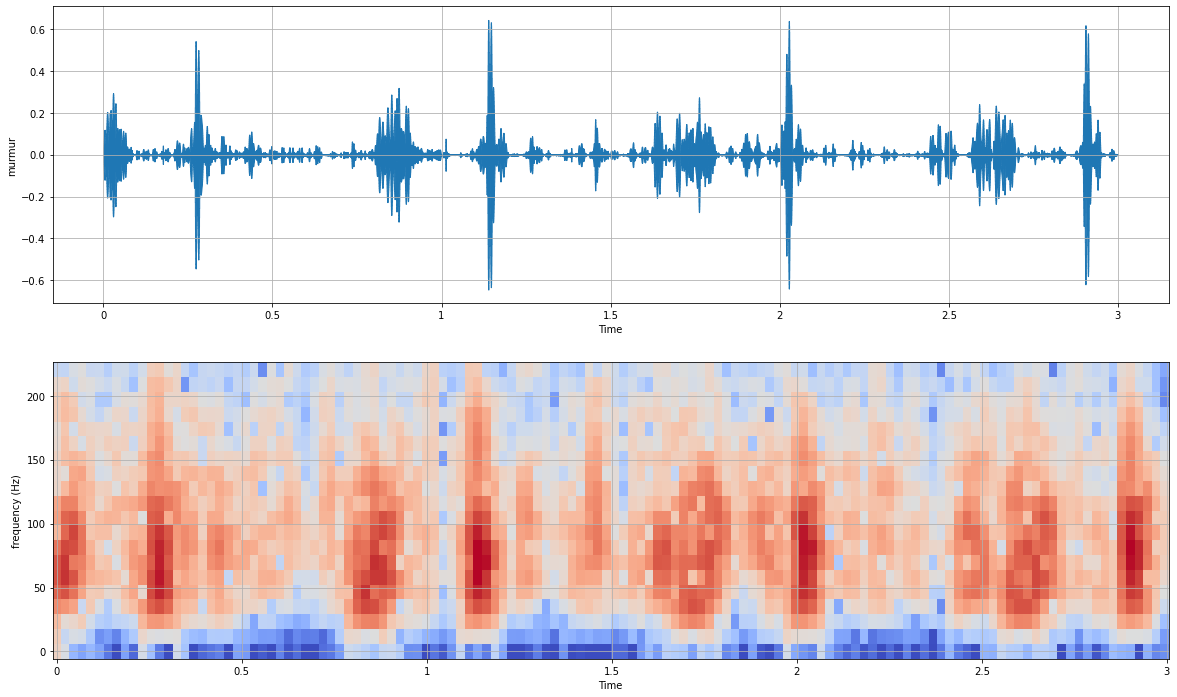


Sample data: murmur
Sample # 1


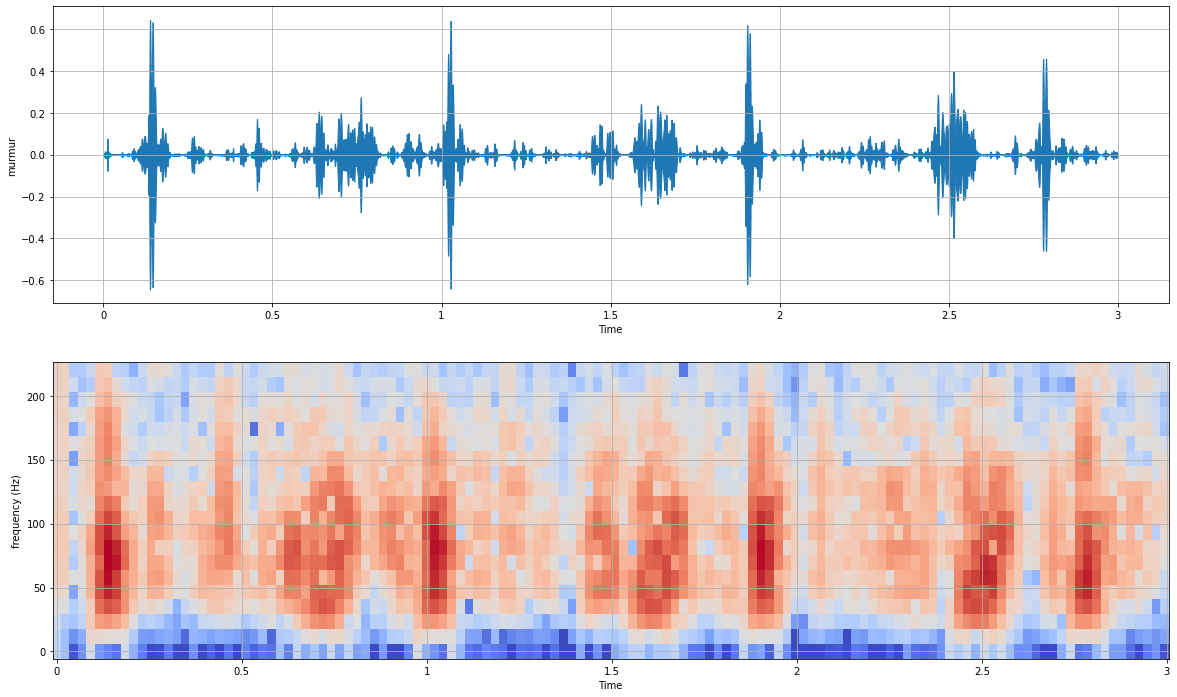


Sample data: murmur
Sample # 2


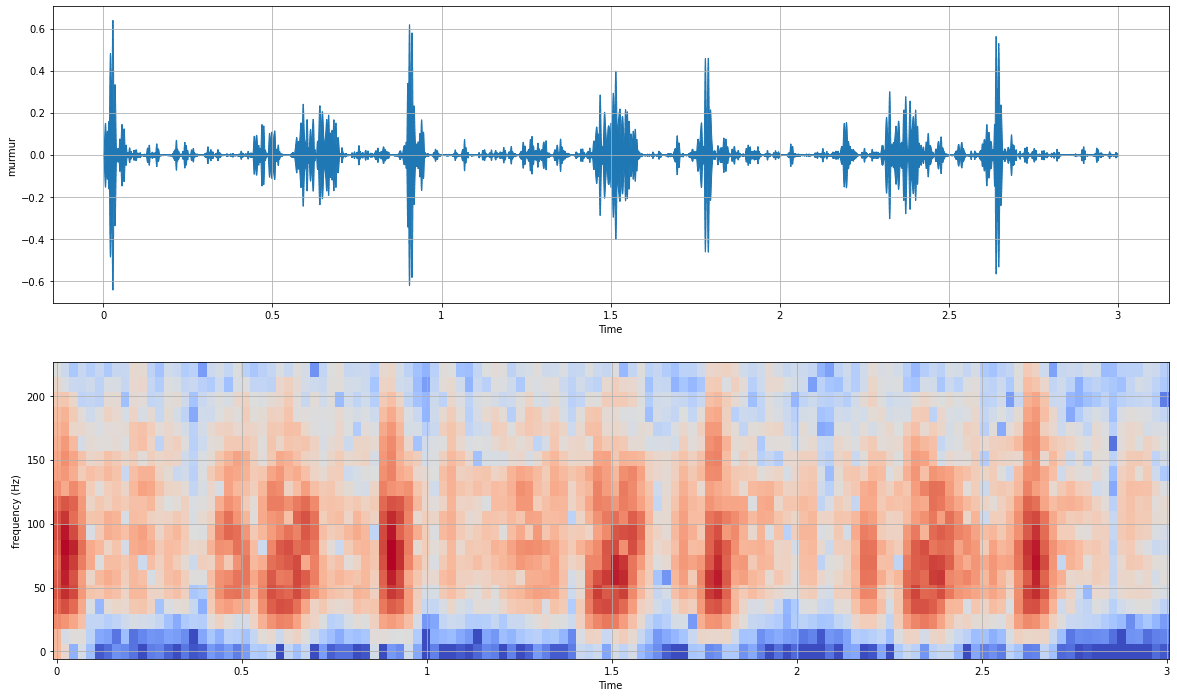


Sample data: murmur
Sample # 3


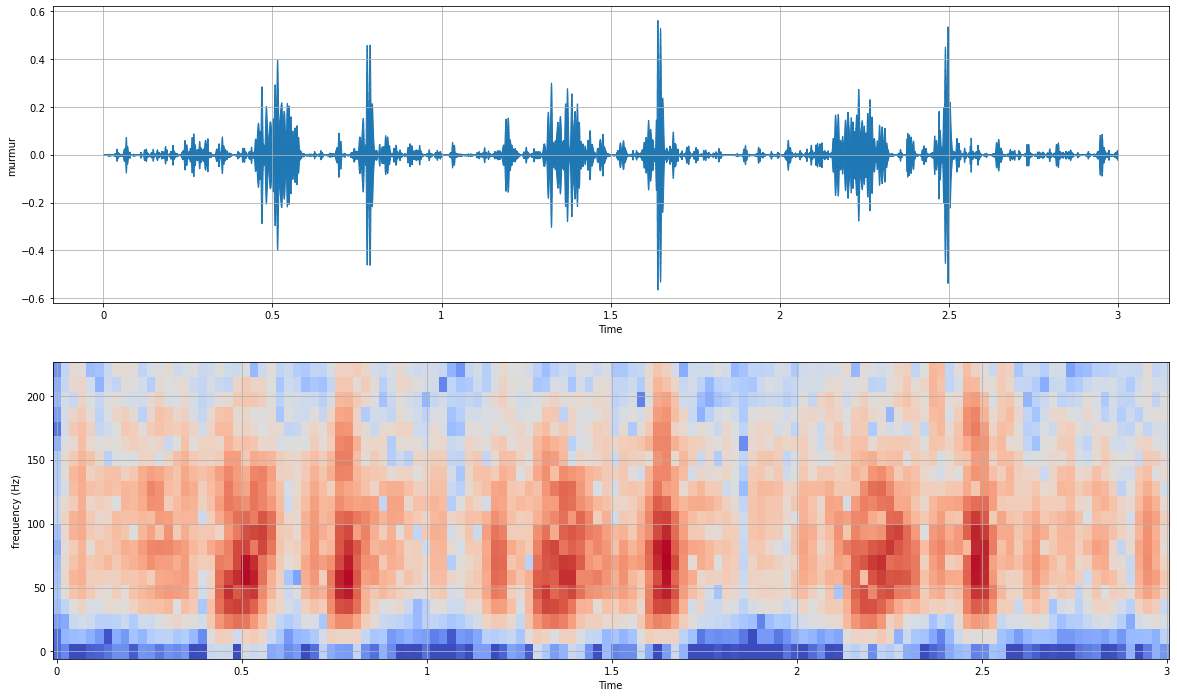


Sample data: murmur
Sample # 4


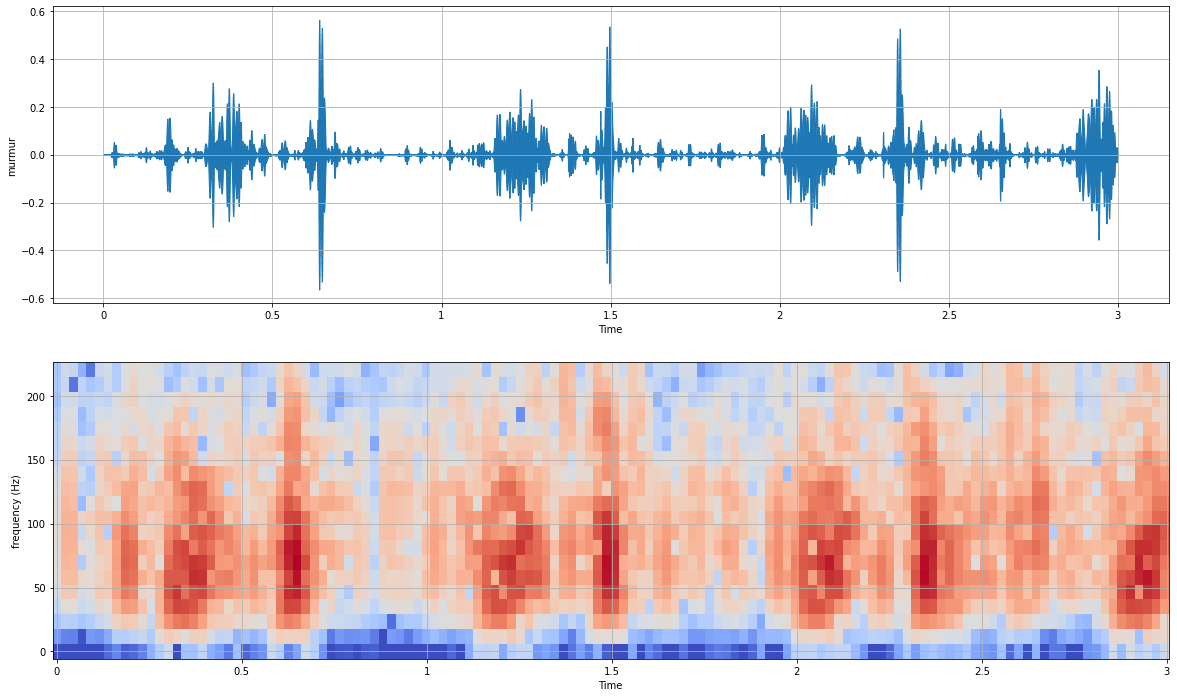


Sample data: murmur
Sample # 5


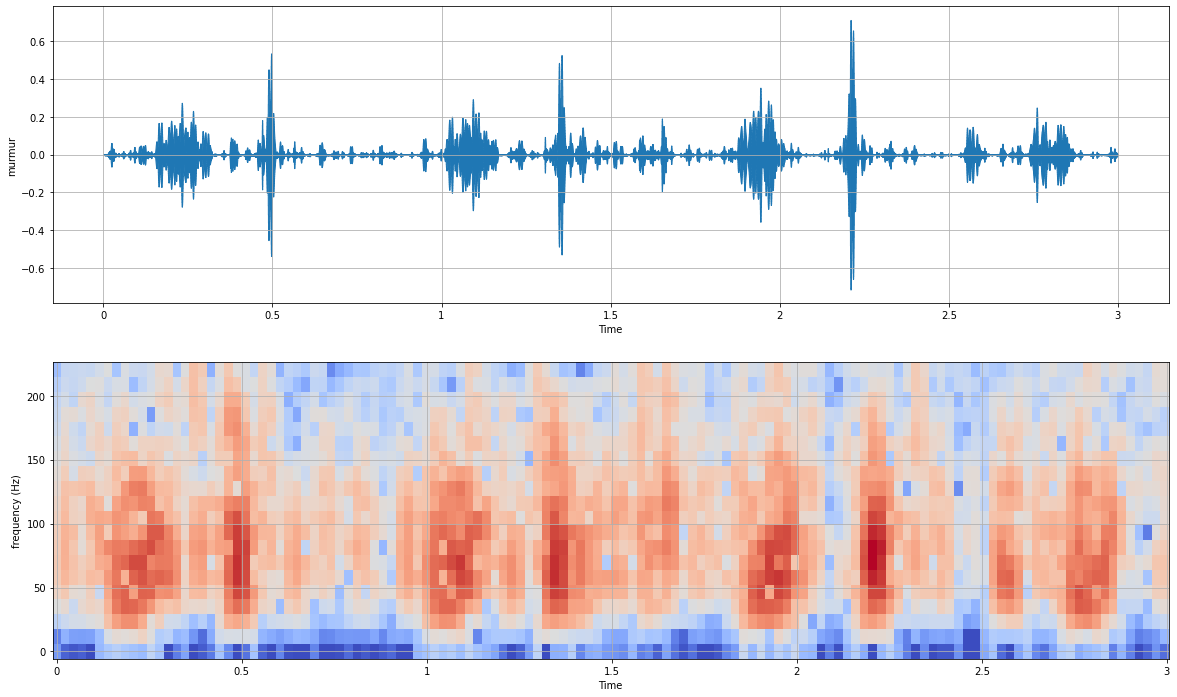


Sample data: murmur
Sample # 6


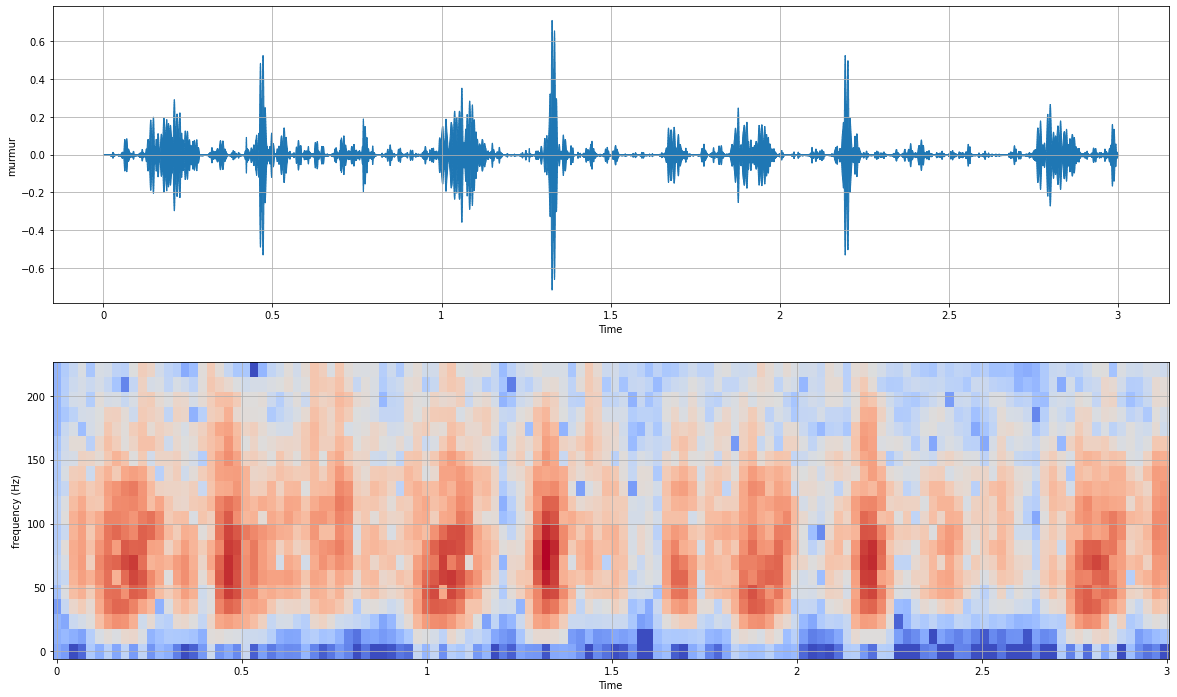

In [13]:
# Draw sample waveforms and the corresponding spectrograms
sample_category = 2 # 0: artifact, 1: normal, 2: murmur, 3: extrahs
idx_show = list(range(0, 7))

if sample_category == 0:
    data_set = data_artifact
    PSD_set = PSD_artifact
elif sample_category == 1:
    data_set = data_normal
    PSD_set = PSD_normal
elif sample_category == 2:
    data_set = data_murmur
    PSD_set = PSD_murmur
elif sample_category == 2:
    data_set = data_extrahs
    PSD_set = PSD_extrahs
else:
    print('Data not exist!')  
    
for idx in idx_show:
    print('Sample data:', label_names[sample_category])
    print('Sample #', idx)
    ipd.display(ipd.Audio(data=data_set[idx], rate=sr))
    plt.figure(figsize=(20,12))
    plt.subplot(2,1,1)
    librosa.display.waveshow(data_set[idx], sr=sr)
    plt.ylabel(label_names[sample_category])
    plt.grid()
    plt.subplot(2,1,2)
    librosa.display.specshow(PSD_set[idx], sr=sr*freq_ratio, hop_length=hop_length*freq_ratio, x_axis='time', y_axis='linear')
    plt.ylabel('frequency (Hz)')
    plt.grid()
    plt.show()
    print()

#### Data combine, convert and shuffle

In [14]:
print('>> Combining the train data & labels ...')
PSD_combine = np.concatenate((PSD_artifact, PSD_normal, PSD_murmur, PSD_extrahs))
label_combine = np.concatenate((label_artifact, label_normal, label_murmur, label_extrahs))
print('Shape of PSD_combine:', PSD_combine.shape)
print('Shape of label_combine:', label_combine.shape)
print()

print('>> Converting data to tf.Dataset format ...')
num_PSD = PSD_combine.shape[0]
PSD_combine = np.expand_dims(PSD_combine, axis=3) # add 4th dimension for CNN
data_set = tf.data.Dataset.from_tensor_slices((PSD_combine, label_combine))
print()

print('>> Shuffling the data ...')
data_set = data_set.shuffle(num_PSD)
print()

print('>> Dividing data into batches ...')
batch_size = 32
data_set = data_set.batch(batch_size=batch_size, drop_remainder=True)
num_batches = len(list(data_set))
print('Total number of batches =', num_batches)
print('The first 3 data batches:')
for data, label in data_set.take(3):
    print('data.shape =', data.shape)
    print('labels =', label.numpy())
print()

print('Splitting batches into train, validation and test groups ...')
val_size = 5
test_size = 3
train_size = num_batches - val_size - test_size

data_train = data_set.take(train_size)
data_val = data_set.skip(train_size).take(val_size)
data_test = data_set.skip(train_size).skip(val_size)

print('The num of batches to train =', len(list(data_train)))
print('The num of batches to validate =', len(list(data_val)))
print('The num of batches to test =', len(list(data_test)))

>> Combining the train data & labels ...
Shape of PSD_combine: (826, 20, 130)
Shape of label_combine: (826,)

>> Converting data to tf.Dataset format ...

>> Shuffling the data ...

>> Dividing data into batches ...
Total number of batches = 25
The first 3 data batches:
data.shape = (32, 20, 130, 1)
labels = [1 0 2 0 1 2 0 0 2 0 1 2 3 3 0 0 0 2 0 0 2 2 3 0 0 3 0 1 0 2 3 2]
data.shape = (32, 20, 130, 1)
labels = [0 2 0 2 1 0 3 0 1 2 0 1 3 2 1 2 3 2 1 0 2 1 1 2 2 1 1 2 1 2 0 1]
data.shape = (32, 20, 130, 1)
labels = [0 0 0 0 0 2 0 2 2 0 0 0 3 2 1 2 1 1 3 1 0 0 3 2 0 0 0 0 1 0 1 0]

Splitting batches into train, validation and test groups ...
The num of batches to train = 17
The num of batches to validate = 5
The num of batches to test = 3


## Machine learning using CNN
Since we are using spectrograms, now the problem becomes classification into 4 categories for a bunch of "pictures". In order to extract important features of "pcitures", convolutional neural network would be a handy tool.

#### Model setup

In [15]:
for batch, _ in data_set.take(1):
    input_shape = batch.shape[1:]
n_classes = 4

model = tf.keras.Sequential([
    layers.Conv2D(32, kernel_size=(2,6), padding='same', activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(2,6), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(2,6), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax') 
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 130, 32)       416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 65, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 65, 64)        24640     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 32, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 32, 64)         49216     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 16, 64)        0

In [16]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
epoches = 20
train_val = model.fit(
    data_train,
    epochs = epoches,
    batch_size = batch_size,
    verbose = 1,
    validation_data = data_val
)

Epoch 1/20
17/17 [==============================] - 8s 13ms/step - loss: 1.8990 - accuracy: 0.4007 - val_loss: 1.1963 - val_accuracy: 0.5375
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 1.0588 - accuracy: 0.6011 - val_loss: 0.9449 - val_accuracy: 0.6562
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.8556 - accuracy: 0.6691 - val_loss: 0.7821 - val_accuracy: 0.6687
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 0.7635 - accuracy: 0.7004 - val_loss: 0.7047 - val_accuracy: 0.7188
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 0.8014 - accuracy: 0.6581 - val_loss: 0.6294 - val_accuracy: 0.7875
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.6492 - accuracy: 0.7408 - val_loss: 0.5558 - val_accuracy: 0.7625
Epoch 7/20
17/17 [==============================] - 0s 6ms/step - loss: 0.5752 - accuracy: 0.7794 - val_loss: 0.5053 - val_accuracy: 0.7875
Epoch 8/20
17/17 [=

In [18]:
scores = model.evaluate(data_test)

3/3 [==============================] - 0s 36ms/step - loss: 0.2475 - accuracy: 0.8750


## Predictions
The sound data to be predicted are not of the same length. Therefore, one may still need to devide the data into sections of 3s. <br>
In particular, each data devision will be put into the machine learning model and get a label of predciton, then all the labels are to be considered to give a final decision of which category should be put into.

In [19]:
def predict_data(file_directory, indices, sr=22050, frame_time=3, hop_time=1):
    files = os.listdir(file_directory)
    frame_len = sr * frame_time
    hop_len = sr * hop_time
    
    print('Looking into file directory -', file_directory)
    for idx in indices:
        file = files[idx]
        
        # data preprocessing
        data, _ = librosa.load(file_directory + '/' + file) # load the file data
        data = data / np.amax(abs(data)) # regulate the magnitude
        if len(data) < frame_len:
            data = librosa.util.fix_length(data, size=frame_len) # Pad the data if len_data < frame_len       
        num_batch = int((len(data)-frame_len)/hop_len) + 1 # calculate number of batches the data can be divided into
        data_batch = np.zeros([num_batch, frame_len])
        for i in range(num_batch):
            data_batch[i] = data[hop_len*i : hop_len*i + frame_len]
        if (len(data)-frame_len) // hop_len != 0:
            data_batch = np.append(data_batch, [data[-frame_len:]], axis=0)
        
        # add band pass filter
        data_batch = band_pass_filter(data_batch, 20, 150, sr/2, axis=1)
        
        # Convert to spectrogram and cut the high frequency part
        frame_size_spec = 2048
        hop_length_spec = 512
        freq_ratio = 0.02
        PSD_batch = get_spectrograms(data_batch, frame_size_spec, hop_length_spec, freq_ratio=freq_ratio, y_axis='linear')
        
        
        # Add 4th dimension and convert to tf.
        PSD_batch = np.expand_dims(PSD_batch, axis=3)
        PSD_batch = tf.convert_to_tensor(PSD_batch)
        
        # use the learned model to make predictions, and store the predictions in the list "predicitons"
        batch_prediction = model.predict(PSD_batch)
        predictions = np.argmax(batch_prediction, axis=1)
        
        
        # Play the sound and the corresponding waveform, show the final prediction and the Certainty of the prediction.
        print('--------------------------------------------')
        print('For data #', idx, ':')
        ipd.display(ipd.Audio(data=data, rate=sr))        
        plt.figure(figsize=(20,6))
        librosa.display.waveshow(data, sr=sr)
        plt.grid()
        plt.show()

        pred_names, ratio = predict_with_certainty(predictions)
        
        print('The heartbeat sound belongs to:', pred_names)
        print('Percentage of certainty =', np.round_(ratio, 4) * 100, '%')
        
                
# This function returns the most frequent indices and the corresponding ratio of occurance
def predict_with_certainty(predict_arr):
    counter = {0: 0, 1: 0, 2: 0, 3: 0}
    max_count, max_item = 0, []
    for item in predict_arr:
        counter[item] += 1
        if counter[item] > max_count:
            max_item = [item]
            max_count = counter[item]
        elif counter[item] == max_count:
            max_item.append(item)
    
    num2name = {0: 'artifact', 1: 'normal', 2: 'murmur', 3: 'extrahs'}
    max_names = []
    for i in max_item:
        max_names.append(num2name[i])
    total_num = len(predict_arr)
    ratio = max_count / total_num
    return (max_names, ratio)

Looking into file directory - data/Aunlabelledtest
--------------------------------------------
For data # 0 :


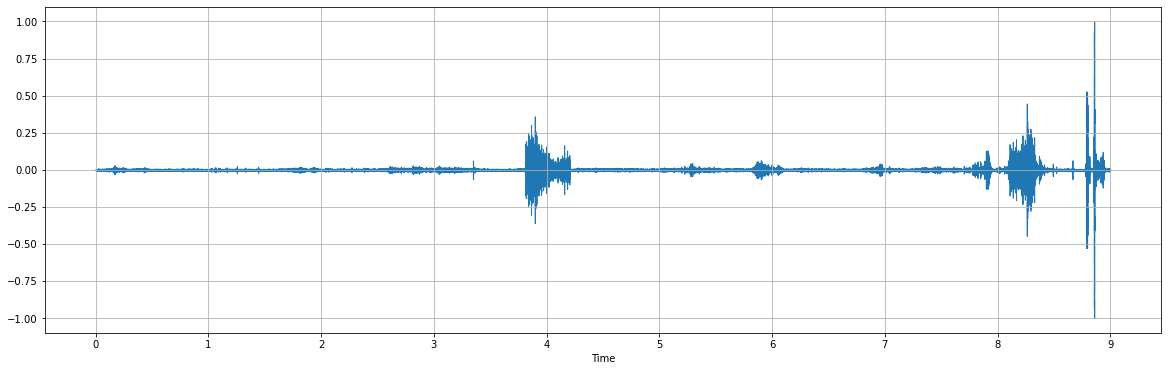

The heartbeat sound belongs to: ['artifact']
Percentage of certainty = 100.0 %
--------------------------------------------
For data # 1 :


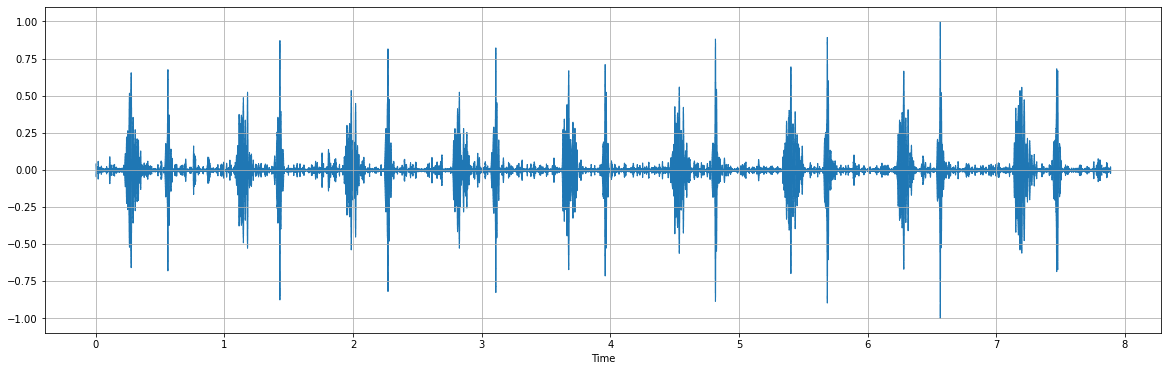

The heartbeat sound belongs to: ['murmur']
Percentage of certainty = 83.33 %
--------------------------------------------
For data # 2 :


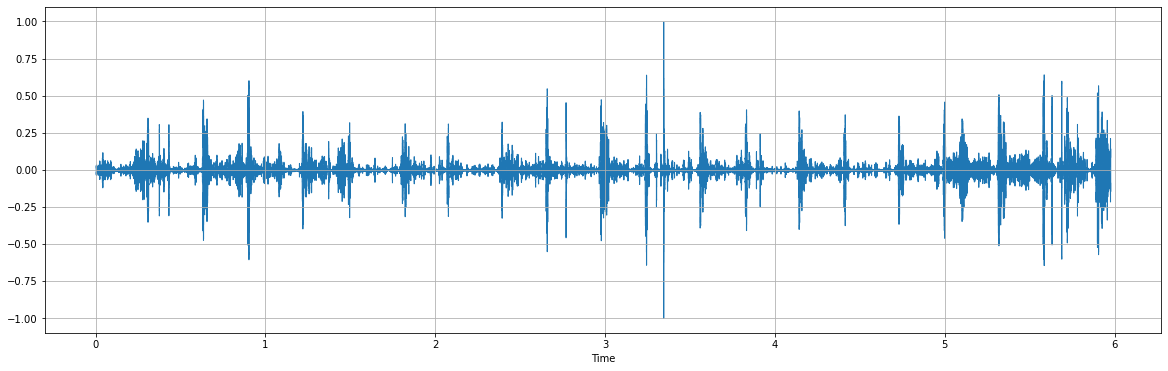

The heartbeat sound belongs to: ['normal', 'extrahs']
Percentage of certainty = 50.0 %
--------------------------------------------
For data # 3 :


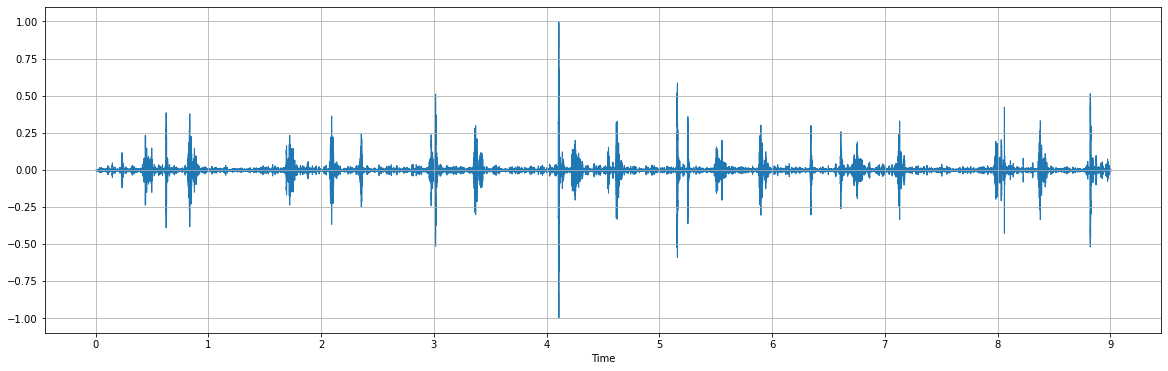

The heartbeat sound belongs to: ['extrahs', 'normal']
Percentage of certainty = 37.5 %
--------------------------------------------
For data # 4 :


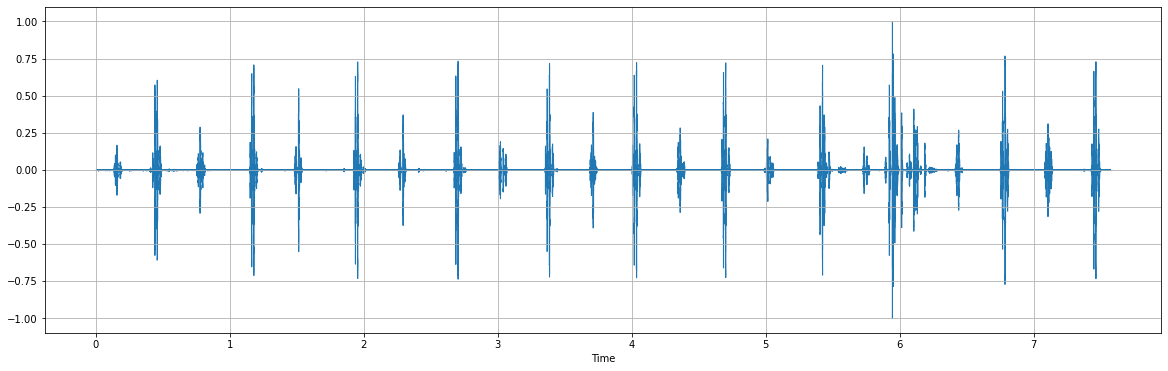

The heartbeat sound belongs to: ['extrahs']
Percentage of certainty = 66.67 %
--------------------------------------------
For data # 5 :


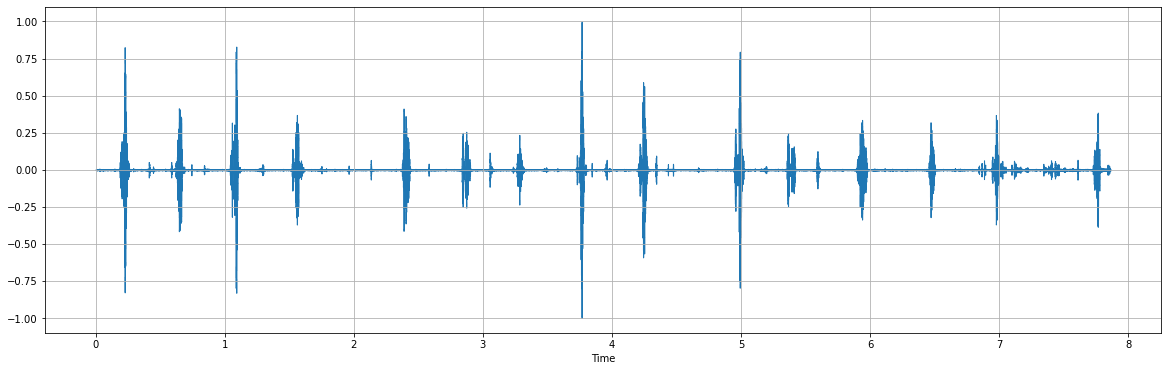

The heartbeat sound belongs to: ['extrahs']
Percentage of certainty = 66.67 %
--------------------------------------------
For data # 6 :


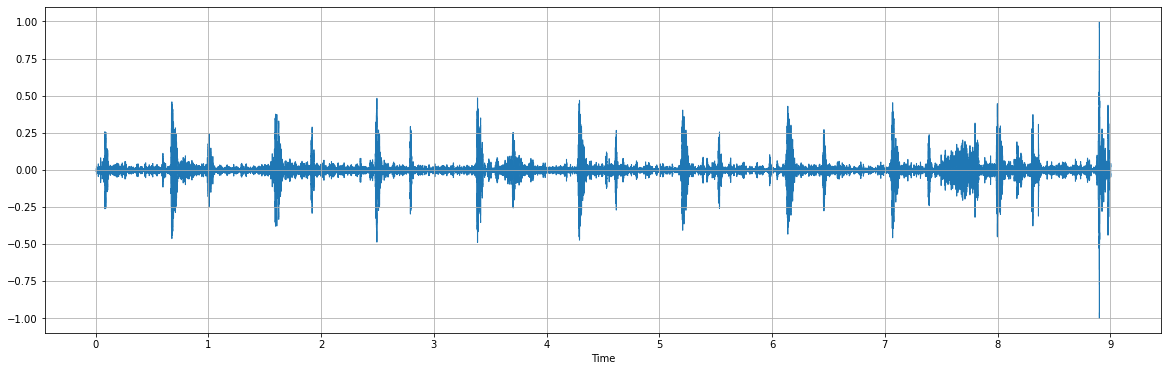

The heartbeat sound belongs to: ['murmur']
Percentage of certainty = 75.0 %
--------------------------------------------
For data # 7 :


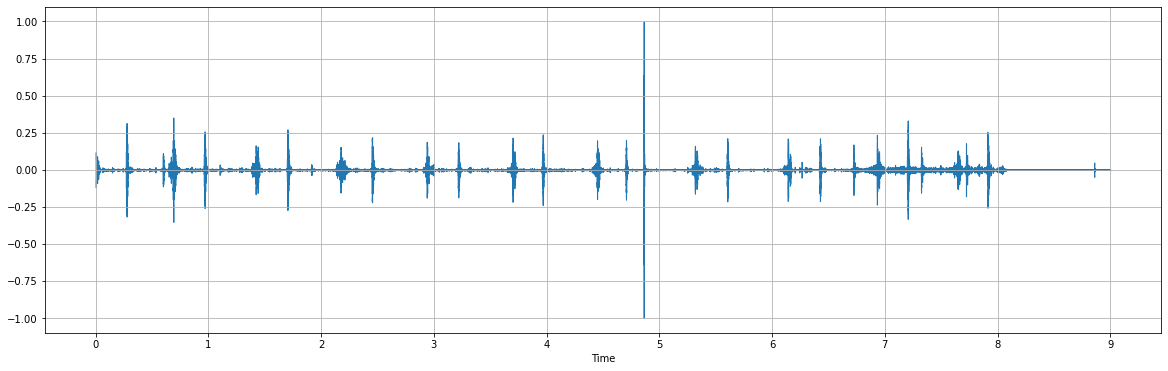

The heartbeat sound belongs to: ['extrahs']
Percentage of certainty = 75.0 %
--------------------------------------------
For data # 8 :


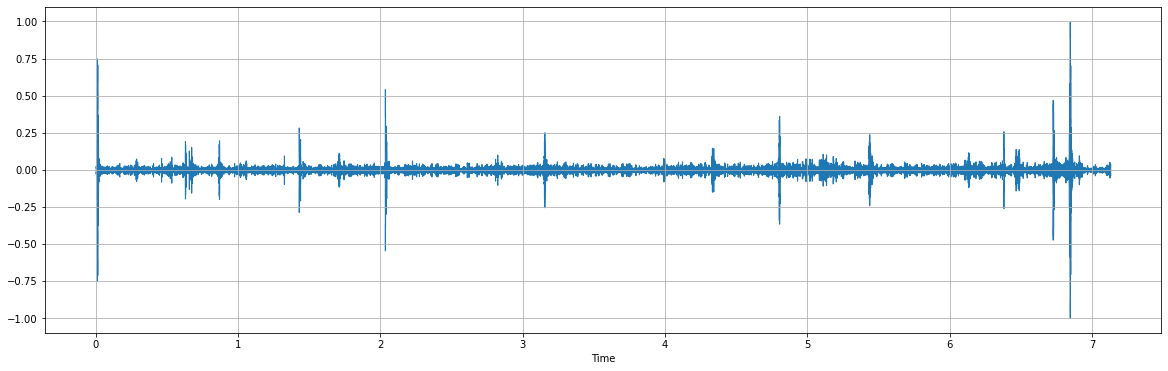

The heartbeat sound belongs to: ['artifact']
Percentage of certainty = 83.33 %
--------------------------------------------
For data # 9 :


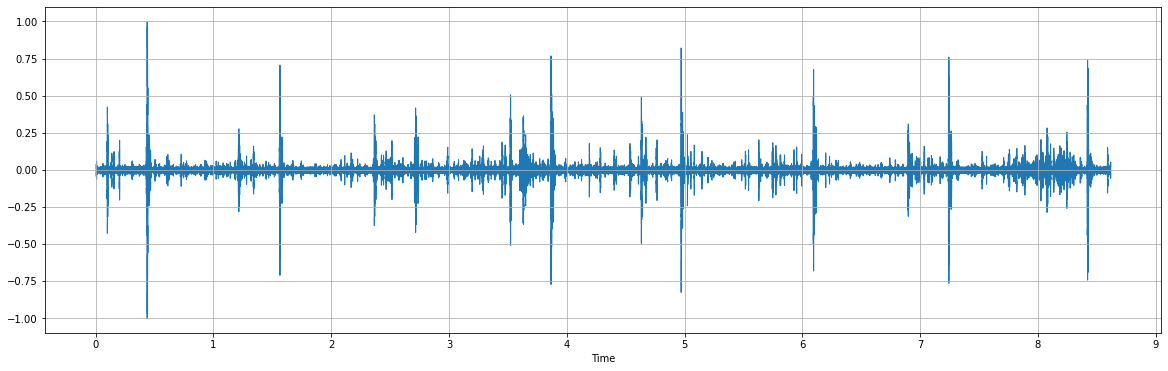

The heartbeat sound belongs to: ['extrahs']
Percentage of certainty = 71.43 %


In [20]:
predict_data('data/Aunlabelledtest',list(range(10)))

In [21]:
model.save('heart_sound_classification_v1.h5')